In [341]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm_notebook, trange
from numba import jit
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.cluster import SpectralClustering

In [2]:
import networkx as nx

In [4]:
os.chdir(r"/raid6/roozbeh/trip_similarity/")

In [5]:
with pd.HDFStore("koln_by_hour_OD_and_scaled.h5") as store:
    OD8df = store["OD8df"] 
    OD8df_scaled = store["OD8df_scaled"]
    OD12df = store["OD12df"]
    OD12df_scaled = store["OD12df_scaled"]
    OD16df = store["OD16df"]
    OD16df_scaled = store["OD16df_scaled"]
    OD20df = store["OD20df"]
    OD20df_scaled = store["OD20df_scaled"]

#### Parameters

In [6]:
spatial_step = 50

time_threshold = 600 #seconds since data is per second

distance_sim_coef = 0.0001
time_sim_coef = 0.00015

In [7]:
x_diff = max(OD8df.x_begin.max(),OD8df.x_end.max()) - min(OD8df.x_begin.min(), OD8df.x_end.min())
y_diff = max(OD8df.y_begin.max(),OD8df.y_end.max()) - min(OD8df.y_begin.min(), OD8df.y_end.min())
min_diff = min(x_diff,y_diff)
min_step = min_diff / spatial_step 
distance_threshold = min_step * np.sqrt(2)
distance_threshold

622.9631611561606

##### We get a sample of 10000 for ongoing rides + 2000 for the requests

In [8]:
ongoingDF = OD8df.sample(n=10000,random_state=1234)

otherDF = OD8df[~ OD8df.index.isin(ongoingDF.index)]

reqDF = otherDF.sample(n=2000,random_state=1234)
reqDF.sort_values("time_begin",inplace=True)

In [21]:
reqDF.reset_index(inplace=True)

#### We want to service all 2k nodes of REQDF with minimum number of cars.

Hence minimum path partitioning of a graph is neeed. The graph is a DAG based on drop off times being less than pick up times. Hence, it has a polynomial time algorithm that works by constructing a bi partitie graph with n nodes on each part where an edge only exists between nodes from left to right if in the DAG a->b then here a in left part and b in right part would have an edge (not directed though). We use this bipartite graph to do maximum weight matching which correponds to the path partitioning in the original DAG.

In [152]:
G = nx.Graph()

In [153]:
G.add_nodes_from([i for i in range(2*len(reqDF))])

In [154]:
N = len(reqDF)

In [155]:
w_x = 0.66
w_t = 1 - w_x
t_th = 900
d_th = 1800
#sim(t1,t2) means t1 happens before t2 (t2 can get the car from t1)
def get_trip_carshare_similarity_from_tuple_wgm(t1,t2):
    do_dist = np.sqrt( (t1.x_end - t2.x_begin) ** 2 + (t1.y_end - t2.y_begin)**2 )
    do_time = np.absolute(t1.time_end - t2.time_begin)
    return(np.exp(w_x * np.log(1./(1+do_dist/d_th)) + w_t * np.log(1./(1+do_time/t_th)) ))

In [156]:
for req in reqDF.itertuples():
#     G.add_edge(req.Index,N + req.Index)
    t_diff = reqDF.time_begin - req.time_end
    potential = reqDF[(0 <= t_diff) & (t_diff <= t_th)]
    d_diff = np.sqrt( (potential.x_begin - req.x_end) ** 2 + (potential.y_begin - req.y_end)**2 )
    potential = potential[d_diff <= d_th]
    if not potential.empty:
        potential["similarity"] = potential.apply(lambda x : get_trip_carshare_similarity_from_tuple_wgm(req,x),axis=1)
        for match in potential.itertuples():
            G.add_edge(req.Index,N+match[0],weight=int(match.similarity*10000))
    

In [157]:
1 < 3 < 5 < 6 #LOL IT WORKS

True

In [158]:
len(G.edges)

38730

In [159]:
max_matching = nx.max_weight_matching(G,maxcardinality=True)

In [160]:
len(max_matching)

1370

In [161]:
matching_formatted = dict()
for u,v in max_matching:
    if u < v:
        matching_formatted[u] = v-N
    else:
        matching_formatted[v] = u-N

In [162]:
set_left = set(matching_formatted.keys())

In [163]:
set_right = set(matching_formatted.values())

In [164]:
len ( set(range(N)) - (set_left | set_right) )

149

In [165]:
N - len(max_matching)

630

In [166]:
N - len(max_matching) - len ( set(range(N)) - (set_left | set_right) )

481

In [167]:
def get_distance(t):
    return(np.sqrt((t.x_begin - t.x_end) ** 2 + (t.y_begin - t.y_end)**2 ))

In [168]:
def get_e2b_distance(t1,t2):
    return(np.sqrt((t2.x_begin - t1.x_end) ** 2 + (t2.y_begin - t1.y_end)**2 ))b

In [314]:
def get_e2b_time(t1,t2):
    return(t2.time_begin - t1.time_end)

In [169]:
reqDF["distance"] = reqDF.apply(get_distance,axis=1)

Index has been reset to 0 to N-1 so using location index instead of integer in pandas works

In [315]:
trip_travels = []
pickup_travels = []
pickup_times = []

In [316]:
for i in set(range(N)) - set_right:
    current = i
    temp_travels = [reqDF.loc[current,"distance"]]
    temp_pickup_travels = []
    temp_pickup_times = []
    while current in set_left:
        _next = matching_formatted[current]
        
        temp_pickup_travels.append(get_e2b_distance(reqDF.loc[current,:],reqDF.loc[_next,:]))
        temp_pickup_times.append(get_e2b_time(reqDF.loc[current,:],reqDF.loc[_next,:]))
        current = _next
        
        temp_travels.append(reqDF.loc[current,"distance"])
        
    pickup_travels.append(temp_pickup_travels)
    trip_travels.append(temp_travels)
    pickup_times.append(temp_pickup_times)

In [176]:
chain_lengths = [len(x) for x in trip_travels]

In [272]:
fig = plt.figure(figsize=(10,6))
ax = sns.distplot(chain_lengths,kde=False,bins=range(11),hist_kws={'width':0.9,'align':'left',"alpha":0.7})
ax.set_xlabel("chain length (count)",fontsize=20)
ax.set_ylabel("frequency",fontsize=20)
ax.set_xticks(range(11))
ax.set_xlim(0,10)
ax.tick_params(axis='both', which='major', labelsize=18)

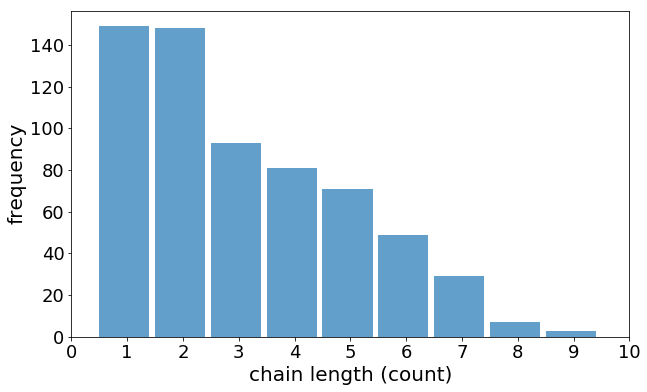

In [273]:
plt.show()

In [248]:
total_trip_travels = [sum(x)/1000 for x in trip_travels]

In [339]:
fig = plt.figure(figsize=(10,6))
ax = sns.distplot(total_trip_travels,kde=False,bins=20,hist_kws={'align':'left',"alpha":0.7,'width':4.})
ax.set_xlabel("total chain travel (km)",fontsize=20)
ax.set_ylabel("frequency",fontsize=20)
# ax.set_xticks(range(11))
# ax.set_xlim(0,10)
ax.tick_params(axis='both', which='major', labelsize=18)

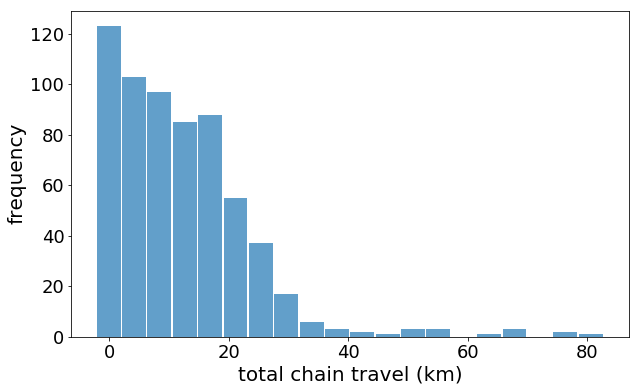

In [340]:
plt.show()

In [304]:
fig = plt.figure(figsize=(10,6))
ax = sns.distplot(total_trip_travels,hist=False, bins=20,kde_kws={'cumulative':True})
ax.set_xlabel("total chain travel (km)",fontsize=20)
ax.set_ylabel("frequency",fontsize=20)
# ax.set_xticks(range(11))
# ax.set_xlim(0,10)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.grid()

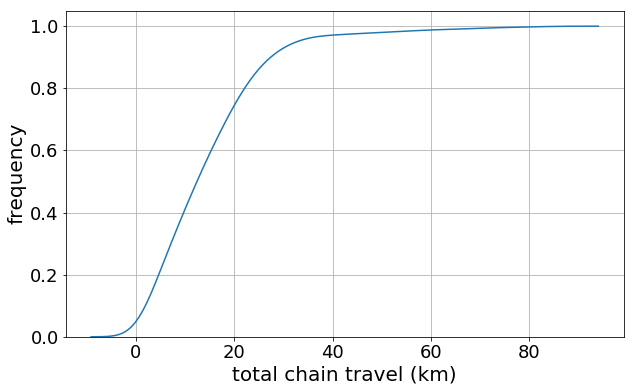

In [305]:
plt.show()

In [278]:
total_pickup_travels = [sum(x)/1000 for x in pickup_travels]

In [331]:
fig = plt.figure(figsize=(10,6))
ax = sns.distplot(total_pickup_travels,kde=False,bins=[i*0.1 for i in range(90)],hist_kws={'align':'left',"alpha":0.7,'width':0.08})
ax.set_xlabel("total travels to pickup (kms)",fontsize=20)
ax.set_ylabel("frequency",fontsize=20)
ax.set_xticks(range(11))
# ax.set_xlim(0,10)
ax.tick_params(axis='both', which='major', labelsize=18)

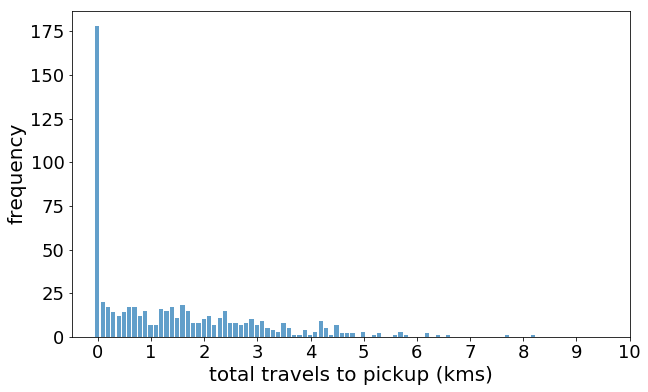

In [332]:
plt.show()

In [349]:
fig = plt.figure(figsize=(10,6))
ax = sns.distplot(total_pickup_travels,hist=False, bins=20,kde_kws={'cumulative':True})
ax.set_xlabel("total travels to pickup (kms)",fontsize=20)
ax.set_ylabel("frequency",fontsize=20)
# ax.set_xticks(range(11))
# ax.set_xlim(0,10)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.grid()

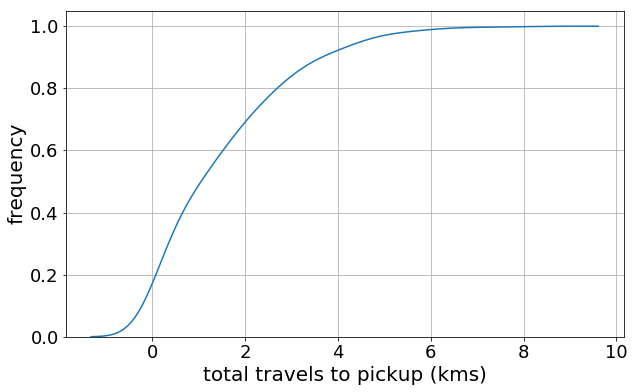

In [350]:
plt.show()

In [351]:
total_pickup_times = [sum(x) for x in pickup_times]

In [352]:
fig = plt.figure(figsize=(10,6))
ax = sns.distplot(total_pickup_times,kde=False,bins=[60*i for i in range(40)],hist_kws={'align':'left',"alpha":0.7,'width':55})
ax.set_xlabel("total time to pickup (s)",fontsize=20)
ax.set_ylabel("frequency",fontsize=20)
# ax.set_xticks(range(11))
# ax.set_xlim(0,10)
ax.tick_params(axis='both', which='major', labelsize=18)

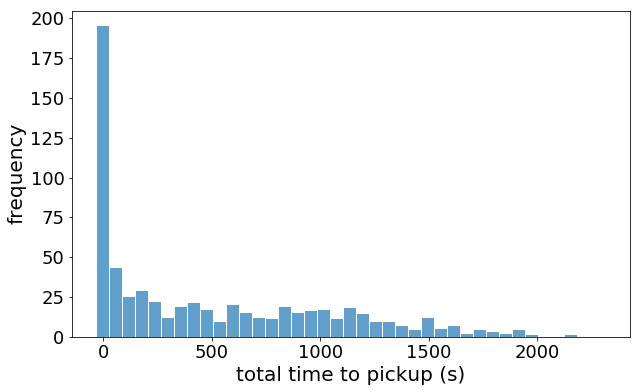

In [353]:
plt.show()

In [354]:
fig = plt.figure(figsize=(10,6))
ax = sns.distplot(total_pickup_times,hist=False, bins=20,kde_kws={'cumulative':True})
ax.set_xlabel("total time to pickup (s)",fontsize=20)
ax.set_ylabel("frequency",fontsize=20)
# ax.set_xticks(range(11))
# ax.set_xlim(0,10)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.grid()

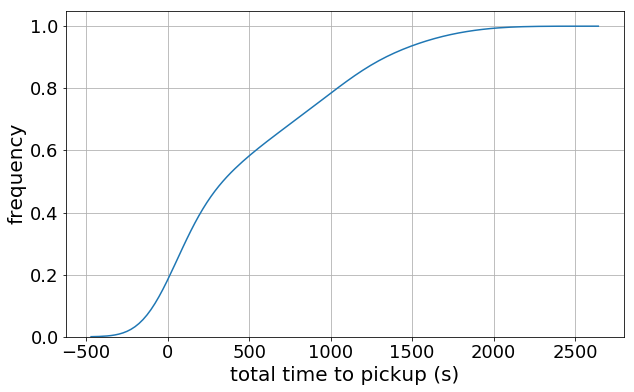

In [355]:
plt.show()